In [22]:
# =====================================================================
# Step 1: Import required libraries and define project directories
# =====================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# Define important project paths
ROOT = Path(".").resolve()
DATA_DIR = ROOT / "BODMAS"
ART_DIR = ROOT / "artifacts"
ART_DIR.mkdir(parents=True, exist_ok=True)

# Configure visualization and pandas options
pd.set_option("display.max_columns", 10)
plt.style.use("seaborn-v0_8-whitegrid")

print(f"Data directory: {DATA_DIR}")

Data directory: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/BODMAS


In [23]:
# =====================================================================
# Step 2: Load the BODMAS dataset
# ---------------------------------------------------------------------
# The dataset contains pre-extracted feature matrices and labels saved
# in NumPy .npz format. Some versions contain pickled Python objects,
# so we enable allow_pickle=True for compatibility.
# =====================================================================

npz_path = DATA_DIR / "bodmas.npz"

# Allow pickle loading since dataset uses object arrays internally
npz = np.load(npz_path, allow_pickle=True)

# Extract features and labels
X = npz["X"]
y = npz["y"].astype(int)

# Load metadata
meta_path = DATA_DIR / "bodmas_metadata.csv"
meta = pd.read_csv(meta_path)

print(f"Feature matrix shape: {X.shape}")
print(f"Label vector shape:   {y.shape}")
print(f"Metadata shape:       {meta.shape}")

# Preview metadata to ensure successful load
meta.head()

Feature matrix shape: (134435, 2381)
Label vector shape:   (134435,)
Metadata shape:       (134435, 3)


,sha,timestamp,family
0,e6d7b4bab32def853ab564410df53fa33172dda1bfd48c...,2007-01-01 08:46:39+00:00,NaN
1,5af37a058a5bcf2284c183ee98d92b7c66d8f5ce623e92...,2007-01-26 17:16:30+00:00,NaN
2,5bfbbea150af5cef2d3a93b80ef7c7faea9f564b56045d...,2007-03-21 02:08:53+00:00,NaN
3,216f592f1e1717d5681b7f5f2b14a28a2f0c603b5b7318...,2007-04-25 12:55:06+00:00,NaN
4,a1ca76813d2e9e7e23b830c87fbe29bcb51fcbe096e445...,2007-11-14 15:03:55+00:00,NaN


In [24]:
# =====================================================================
# Step 3: Data Cleaning and Validation
# ---------------------------------------------------------------------
# Objectives:
#   1. Ensure valid SHA identifiers (64-character strings)
#   2. Parse timestamps into datetime format
#   3. Verify that the number of samples in features, labels, and
#      metadata are perfectly aligned
#   4. Remove or flag any corrupted or incomplete records
# =====================================================================

# Convert the timestamp column to datetime objects.
# Any unparseable entries will become NaT (missing values).
meta["timestamp"] = pd.to_datetime(meta["timestamp"], utc=True, errors="coerce")

# Check for invalid timestamps.
invalid_timestamps = meta["timestamp"].isna().sum()
if invalid_timestamps > 0:
    print(f"Warning: {invalid_timestamps} invalid timestamps found. These entries will be removed.")

# Identify rows with proper SHA hashes (64-character hexadecimal strings).
valid_sha_mask = meta["sha"].astype(str).str.len() == 64

# Apply cleaning mask to all datasets to maintain alignment.
X = X[valid_sha_mask]
y = y[valid_sha_mask]
meta = meta.loc[valid_sha_mask].reset_index(drop=True)

# Remove rows where timestamp could not be parsed.
valid_timestamp_mask = meta["timestamp"].notna()
X = X[valid_timestamp_mask]
y = y[valid_timestamp_mask]
meta = meta.loc[valid_timestamp_mask].reset_index(drop=True)

# Confirm alignment.
assert len(X) == len(y) == len(meta), "Data misalignment detected after cleaning."

# Display summary of the cleaned dataset.
print("Dataset after cleaning:")
print(f"  Total samples: {len(y)}")
print(f"  Benign samples: {(y == 0).sum()}")
print(f"  Malware samples: {(y == 1).sum()}")
print(f"  Missing timestamps removed: {invalid_timestamps}")
print(f"  Remaining valid timestamps: {meta['timestamp'].notna().sum()}")

Dataset after cleaning:
  Total samples: 130716
  Benign samples: 73423
  Malware samples: 57293
  Missing timestamps removed: 3712
  Remaining valid timestamps: 130716


/var/folders/0_/2jfg6k954vx44d4w9209s0tw0000gn/T/ipykernel_15068/3548545378.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, ax=axes[0], palette="Set2")


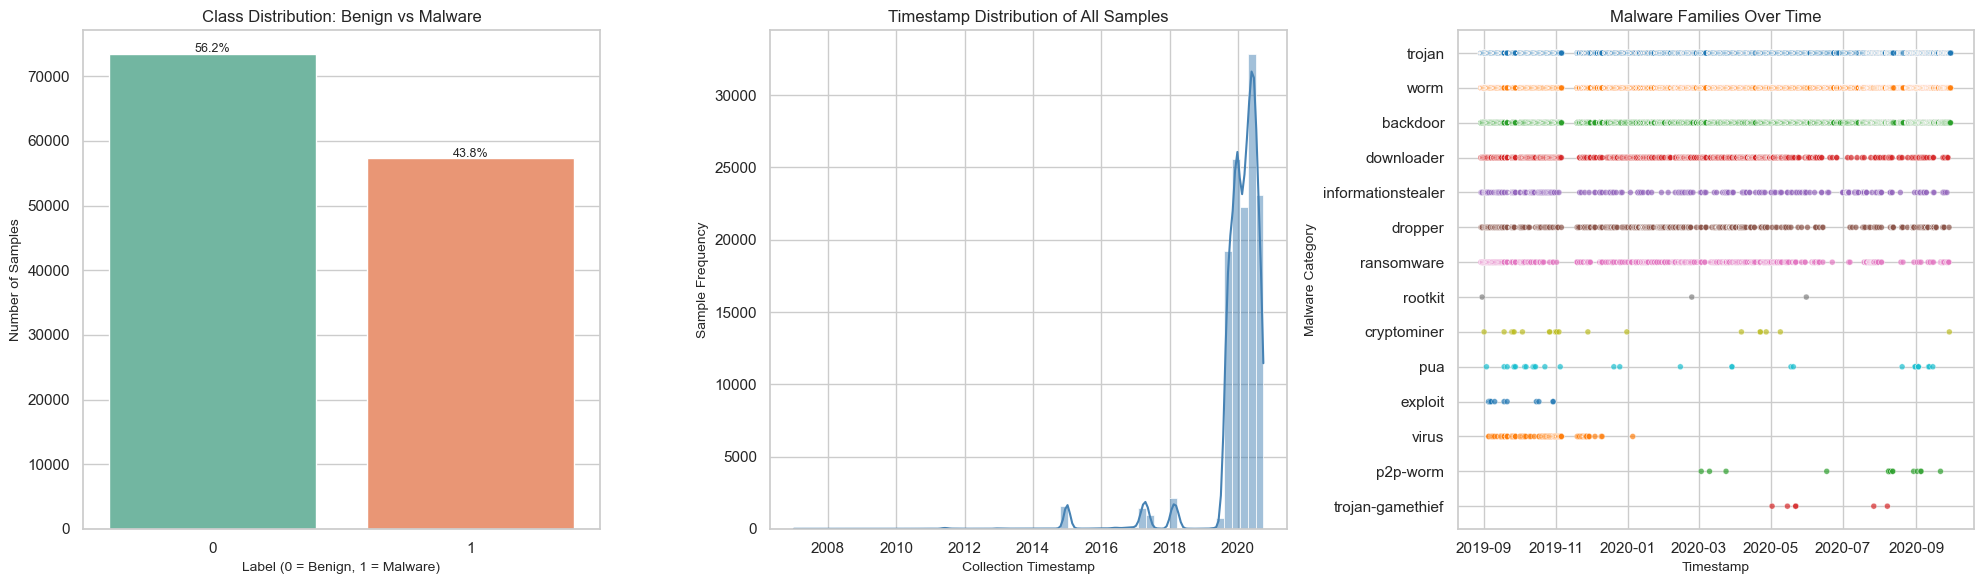

Timestamp Summary:
  Earliest sample : 2007-01-01 08:46:39+00:00
  Latest sample   : 2020-09-30 03:05:27+00:00
  Date range span : 5020 days
  Unique malware families: 14


In [16]:
# =====================================================================
# Step 4: Exploratory Data Analysis (EDA)
# ---------------------------------------------------------------------
# Objectives:
#   1. Visualize class distribution (benign vs malware)
#   2. Examine overall timestamp distribution
#   3. Display malware family occurrences over time
#
# Notes:
#   - This step is purely analytical; no model training occurs here.
#   - The merged 'category' column is required for Plot 3.
# =====================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------------------
# Load malware-family categories and merge into metadata
# ---------------------------------------------------------------------
cat_path = DATA_DIR / "bodmas_malware_category.csv"
malware_categories = pd.read_csv(cat_path)

# Rename column for consistent join key if needed
malware_categories.rename(columns={"sha256": "sha"}, inplace=True)

# Merge category labels into metadata (left join keeps all samples)
meta = meta.merge(malware_categories, on="sha", how="left")

# ---------------------------------------------------------------------
# Configure plot aesthetics
# ---------------------------------------------------------------------
sns.set_theme(style="whitegrid", palette="muted")

# Create a 1×3 figure layout
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# ============================================================
# Plot 1: Class distribution (Benign vs Malware)
# ============================================================
class_counts = pd.Series(y).value_counts().sort_index()
sns.barplot(x=class_counts.index, y=class_counts.values, ax=axes[0], palette="Set2")

axes[0].set_title("Class Distribution: Benign vs Malware", fontsize=12)
axes[0].set_xlabel("Label (0 = Benign, 1 = Malware)", fontsize=10)
axes[0].set_ylabel("Number of Samples", fontsize=10)

# Annotate percentages on top of bars
for i, count in enumerate(class_counts.values):
    percent = count / len(y) * 100
    axes[0].text(i, count + (len(y) * 0.002), f"{percent:.1f}%", ha="center", fontsize=9)

# ============================================================
# Plot 2: Overall timestamp distribution
# ============================================================
meta_sorted = meta.sort_values("timestamp")
sns.histplot(
    data=meta_sorted,
    x="timestamp",
    bins=60,
    kde=True,
    color="steelblue",
    ax=axes[1]
)

axes[1].set_title("Timestamp Distribution of All Samples", fontsize=12)
axes[1].set_xlabel("Collection Timestamp", fontsize=10)
axes[1].set_ylabel("Sample Frequency", fontsize=10)

# ============================================================
# Plot 3: Malware families over time (scatter plot)
# ============================================================
# Filter only samples that have a known malware category
meta_malware = meta[meta["category"].notna()].sort_values("timestamp")

# Build a color palette matching the number of unique families
unique_cats = meta_malware["category"].nunique()
palette = sns.color_palette("tab10", n_colors=unique_cats)

# Scatter plot: each point is a malware sample
sns.scatterplot(
    data=meta_malware,
    x="timestamp",
    y="category",
    hue="category",
    palette=palette,
    s=18,
    alpha=0.7,
    ax=axes[2],
    legend=False
)

axes[2].set_title("Malware Families Over Time", fontsize=12)
axes[2].set_xlabel("Timestamp", fontsize=10)
axes[2].set_ylabel("Malware Category", fontsize=10)

# ---------------------------------------------------------------------
# Render all plots
# ---------------------------------------------------------------------
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# Basic temporal summary for reference
# ---------------------------------------------------------------------
print("Timestamp Summary:")
print(f"  Earliest sample : {meta['timestamp'].min()}")
print(f"  Latest sample   : {meta['timestamp'].max()}")
print(f"  Date range span : {(meta['timestamp'].max() - meta['timestamp'].min()).days} days")
print(f"  Unique malware families: {unique_cats}")

In [25]:
# =====================================================================
# Step 5: Time-Aware Dataset Splitting
# ---------------------------------------------------------------------
# Objectives:
#   1. Split samples chronologically into Train, Validation, and Test sets.
#   2. Maintain the natural time progression of malware evolution.
#   3. Save index arrays for reproducibility.
#
# Split proportions:
#   - Training:    70%  (oldest data)
#   - Validation:  15%  (middle period)
#   - Test:        15%  (most recent data)
# =====================================================================

def time_based_split(metadata: pd.DataFrame,
                     train_fraction: float = 0.70,
                     val_fraction: float = 0.15):
    """
    Split dataset indices into chronological Train/Val/Test subsets.

    Parameters
    ----------
    metadata : pd.DataFrame
        DataFrame containing a 'timestamp' column.
    train_fraction : float
        Fraction of earliest samples for training.
    val_fraction : float
        Fraction of middle samples for validation.

    Returns
    -------
    tuple of np.ndarray
        (train_indices, val_indices, test_indices)
    """
    # Convert timestamps to integer nanoseconds for quantile calculation
    timestamps = metadata["timestamp"].astype("int64")

    # Compute boundaries for train and validation quantiles
    q_train, q_val = np.nanquantile(timestamps, [train_fraction, train_fraction + val_fraction])

    # Create index arrays for each split
    idx_train = metadata.index[timestamps <= q_train].to_numpy()
    idx_val   = metadata.index[(timestamps > q_train) & (timestamps <= q_val)].to_numpy()
    idx_test  = metadata.index[timestamps > q_val].to_numpy()

    return idx_train, idx_val, idx_test


# ---------------------------------------------------------------------
# Apply the splitting function
# ---------------------------------------------------------------------
idx_train, idx_val, idx_test = time_based_split(meta)

# ---------------------------------------------------------------------
# Display split statistics and boundaries
# ---------------------------------------------------------------------
n_total = len(meta)
print("Dataset split summary (chronological):")
print(f"  Training samples   : {len(idx_train)}  ({len(idx_train)/n_total:.1%})")
print(f"  Validation samples : {len(idx_val)}  ({len(idx_val)/n_total:.1%})")
print(f"  Test samples       : {len(idx_test)}  ({len(idx_test)/n_total:.1%})")

print("\nTime range per subset:")
print(f"  Train start : {meta.loc[idx_train, 'timestamp'].min()}")
print(f"  Train end   : {meta.loc[idx_train, 'timestamp'].max()}")
print(f"  Val start   : {meta.loc[idx_val, 'timestamp'].min()}")
print(f"  Val end     : {meta.loc[idx_val, 'timestamp'].max()}")
print(f"  Test start  : {meta.loc[idx_test, 'timestamp'].min()}")
print(f"  Test end    : {meta.loc[idx_test, 'timestamp'].max()}")

# ---------------------------------------------------------------------
# Integrity check to ensure no overlap between subsets
# ---------------------------------------------------------------------
assert set(idx_train).isdisjoint(idx_val)
assert set(idx_val).isdisjoint(idx_test)
assert set(idx_train).isdisjoint(idx_test)
print("\nVerification passed: No overlap between subsets.")

Dataset split summary (chronological):
  Training samples   : 91501  (70.0%)
  Validation samples : 19608  (15.0%)
  Test samples       : 19607  (15.0%)

Time range per subset:
  Train start : 2007-01-01 08:46:39+00:00
  Train end   : 2020-05-30 23:00:50+00:00
  Val start   : 2020-05-30 23:01:16+00:00
  Val end     : 2020-07-17 07:19:30+00:00
  Test start  : 2020-07-17 07:19:31+00:00
  Test end    : 2020-09-30 03:05:27+00:00

Verification passed: No overlap between subsets.


In [26]:
# =====================================================================
# Step 6: Scale numerical features and save preprocessing artifacts
# ---------------------------------------------------------------------
# Objectives:
#   1. Fit StandardScaler on training data only (no leakage).
#   2. Persist scaler and split indices for reproducibility.
# =====================================================================

from sklearn.preprocessing import StandardScaler
import joblib, json, numpy as np

# Fit scaler on training data only
scaler = StandardScaler()
scaler.fit(X[idx_train])

# Create artifacts directory if it does not exist
ART_DIR.mkdir(parents=True, exist_ok=True)

# Save the scaler for reuse in feature engineering and modeling
joblib.dump(scaler, ART_DIR / "scaler.joblib")

# Save the full dataset and split indices
np.savez_compressed(
    ART_DIR / "Xy_splits.npz",
    X=X,
    y=y,
    idx_train=idx_train,
    idx_val=idx_val,
    idx_test=idx_test
)

# Save split size summary
split_summary = {
    "train": int(len(idx_train)),
    "val": int(len(idx_val)),
    "test": int(len(idx_test))
}
json.dump(split_summary, open(ART_DIR / "splits.json", "w"), indent=2)

print("Preprocessing artifacts saved successfully in:", ART_DIR)
for file in ART_DIR.iterdir():
    print(" -", file.name)

Preprocessing artifacts saved successfully in: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/artifacts
 - splits.json
 - scaler.joblib
 - eda.json
 - Xy_splits.npz


In [27]:
# =====================================================================
# Step 7: Save EDA summary for reporting
# ---------------------------------------------------------------------
# Captures dataset-level statistics for documentation or downstream use.
# =====================================================================

eda_summary = {
    "total_samples": int(len(y)),
    "n_features": int(X.shape[1]),
    "class_counts": {
        "benign": int((y == 0).sum()),
        "malware": int((y == 1).sum())
    },
    "date_range": {
        "min": str(meta["timestamp"].min()),
        "max": str(meta["timestamp"].max())
    }
}

json.dump(eda_summary, open(ART_DIR / "eda.json", "w"), indent=2)
print("EDA summary written to:", ART_DIR / "eda.json")

EDA summary written to: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/artifacts/eda.json


In [28]:
# =====================================================================
# Step 8: Verify that artifacts load correctly
# =====================================================================

import json

print("Files in artifacts/:")
for p in ART_DIR.iterdir():
    print(" -", p.name)

# Load back to confirm integrity
s = np.load(ART_DIR / "Xy_splits.npz")
scaler_check = joblib.load(ART_DIR / "scaler.joblib")
eda_check = json.load(open(ART_DIR / "eda.json"))

print("\nVerification:")
print("Scaler fitted on:", scaler_check.mean_.shape[0], "features")
print("Train size:", len(s["idx_train"]))
print("Val size:", len(s["idx_val"]))
print("Test size:", len(s["idx_test"]))
print("EDA summary:", eda_check)

Files in artifacts/:
 - splits.json
 - scaler.joblib
 - eda.json
 - Xy_splits.npz

Verification:
Scaler fitted on: 2381 features
Train size: 91501
Val size: 19608
Test size: 19607
EDA summary: {'total_samples': 130716, 'n_features': 2381, 'class_counts': {'benign': 73423, 'malware': 57293}, 'date_range': {'min': '2007-01-01 08:46:39+00:00', 'max': '2020-09-30 03:05:27+00:00'}}
